In [77]:
import numpy as np
from random import *
import matplotlib.pyplot as plt
import os

In [117]:
def resetSpielfeld():
    spielfeld = np.zeros([10,10])
    spielfeld[0,:] = 2
    spielfeld[9,:] = 2
    spielfeld[:,0] = 2
    spielfeld[:,9] = 2
    return spielfeld.astype(int)

def placeCoins(spielfeld):
    allowed_pos = []
    position = np.arange(100)
    position = position[10:90]
    for j in position:
        if not "0" in str(j) and not "9" in str(j) and str(j) != "11" and str(j) != "18" and str(j) != "81" and str(j) != "88":
            allowed_pos.append(j)
    allowed_pos = np.asarray(allowed_pos)
    allowed_pos_working_area = allowed_pos
    for j in range(6):
        coin_pos = np.random.choice(allowed_pos_working_area)
        x = coin_pos // 10
        y = coin_pos % 10
        allowed_pos_working_area = np.delete(allowed_pos_working_area, np.where(allowed_pos_working_area == coin_pos))
        spielfeld[x, y] = 1
    return spielfeld 

In [3]:
def get_following_state(state, spielfeld, choice, actions, wall_sensitive):
    n_state = np.array([0,0])
    if(choice == "down"):
        n_state[0] = state[0] + 1
        n_state[1] = state[1]
    elif(choice == "up"):
        n_state[0] = state[0] - 1
        n_state[1] = state[1]
    elif(choice == "left"):
        n_state[0] = state[0]
        n_state[1] = state[1] - 1
    elif(choice == "right"):
        n_state[0] = state[0]
        n_state[1] = state[1] + 1
    elif(choice == "wait"):
        n_state[0] = state[0]
        n_state[1] = state[1]
    if wall_sensitive and spielfeld[n_state[0], n_state[1]] == 2:
        # return old state if action is not possible
        return state
    
    return n_state

def get_reward(state,spielfeld,action, step, coins_found):
    x,y = 0,0
    if action == "left":
        x = -1
    if action == "right":
        x = 1
    if action == "down":
        y = 1
    if action == "up":
        y = -1
    
    y +=state[0]
    x +=state[1] 
    
    copy = np.copy(spielfeld)
    copy[state[0], state[1]] = 8
    # print(copy)
    if spielfeld[y,x] == 1:
        # collect coin
        # print("COIN COLLECTED " + str(step))
        spielfeld[y,x] = 0
        return 1000, spielfeld, coins_found+1
    elif spielfeld[y,x] == 2:
        # Mauer
        return -10, spielfeld, coins_found
    else:
        return -1, spielfeld, coins_found

In [4]:
def get_observation(spielfeld, y, x):
    # Suche den Coin, der am nächsten ist (manhattan distance)
    coinsY, coinsX = np.where(spielfeld == 1)
    distancesY = np.abs(coinsY - y)
    distancesX = np.abs(coinsX - x)
    observation = np.array([0, 0,0,0,0]) 
    # 1. Richtung des nächsten Coins: (1,2,3,4:links,oben,rechts,unten)
    # 2. Direkte Umgebung: (links, oben, rechts, unten; 0=frei, 1 = Coin, 2 = Wand)
 
    if not distancesY.shape[0] == 0:
        distances = distancesY + distancesX
        coinY = coinsY[np.argmin(distances)]
        coinX = coinsX[np.argmin(distances)]
        # setze observation flags:
        if coinX < x:
            observation[0] = 1
        elif coinX > x:
            observation[0] = 3
        elif coinY > y:
            observation[0] = 2
        elif coinY < y:
            observation[0] = 4
    
    observation[1] = get_spielfeld(y, x - 1,spielfeld)
    observation[2] = get_spielfeld(y - 1, x,spielfeld)
    observation[3] = get_spielfeld(y, x + 1,spielfeld)
    observation[4] = get_spielfeld(y + 1, x,spielfeld)
    # links, oben, rechts, unten
    # print(x,y, observation)
    return observation

def update_and_get_obs(db, new_obs, learned):
    for i in range(db.shape[0]):
        if np.array_equal(db[i], new_obs):
            return db, i, learned
    db = np.append(db,np.array([new_obs]), axis = 0)
    learned = np.append(learned, np.zeros([1,learned.shape[1]]), axis = 0)
    return db, (db.shape[0] - 1), learned

def get_spielfeld(y,x,spielfeld):
    if y > spielfeld.shape[0] - 1 or x > spielfeld.shape[1] - 1 or y < 0 or x < 0:
        return 2
    else:
        return spielfeld[y,x]

In [5]:
def train_and_test(epsilon, learning_rate, discount, spielfeld):
    reihe = np.array([0])
    learned = np.zeros([0,4])
    obs = np.zeros([0,5])
    
    print("Training:")
    for i in range(1000):
        state = [np.random.choice([1,8]),np.random.choice([1,8])]
#         Place coins randomly but not into corners
        spielfeld = resetSpielfeld()
        spielfeld = placeCoins(spielfeld)
        learned, obs, reihe, epsilon = do_action(state, np.copy(spielfeld), learned, epsilon, obs, reihe, False, learning_rate, discount)

    plt.plot(reihe)
    plt.show()
    print(learned)
    
    reihe = np.array([0])
    print("Learned Observations: " + str(learned.shape[0]))
    print("Test:")
    for i in range(100):
        state = [np.random.choice(np.arange(8)) + 1,np.random.choice(np.arange(8)) + 1]
        learned, obs, reihe, epsilon = do_action(state, np.copy(spielfeld), learned, np.copy(epsilon), obs, reihe, True, learning_rate, discount)

    plt.plot(reihe)
    plt.show()
    
def do_action(state, spielfeld, learned, epsilon, obs, reihe, testmodus, learning_rate, discount):
    actions = np.array(["down", "up", "left", "right"])
    last_action_index = -1
    last_index = -1
    last_reward = -1
    coins_found = 0
    reihenvalue = 0
    for i in range(1000):
        if epsilon > 0.15:
            epsilon = epsilon - 0.02
        
        current_obs = get_observation(spielfeld, state[0], state[1])
        obs, index_current, learned = update_and_get_obs(obs, current_obs, learned)
        if epsilon > uniform(0,1) and not testmodus:
            choice = np.random.choice(np.arange(actions.shape[0]))
        else:
            choice = np.random.choice(np.flatnonzero(learned[index_current] == learned[index_current].max()))
                
        my_best_value = np.max(learned[index_current])
        # print(actions[choice])
        n_state = get_following_state(state, spielfeld, actions[choice], actions, True)
        if (not last_index == -1) and (not testmodus):
            learned[last_index, last_action_index] = (1-learning_rate) * learned[last_index, last_action_index] + learning_rate * (last_reward + discount * my_best_value)
            
        last_reward, spielfeld, coins_found = get_reward(state,spielfeld,actions[choice], i, coins_found)
        last_action_index = choice
        last_index = index_current
        state = n_state
        # print(actions[choice])
        if coins_found == 5:
            reihenvalue = i
            break
                
    reihe = np.append(reihe, np.array([reihenvalue]))
    return learned, obs, reihe, epsilon

Training:


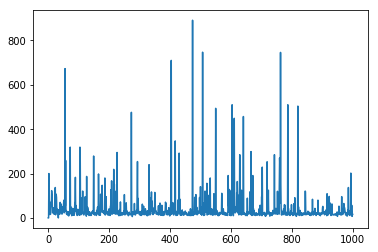

[[-9.10000000e+00  4.33646393e+02  0.00000000e+00  1.18775920e+03]
 [ 1.68848319e+02  1.69888515e+02  8.26322058e+01  5.90402298e+02]
 [ 1.59476590e+02  5.51134131e+02  2.79532968e+02  1.02102680e+02]
 [ 7.26536584e+02  1.35156516e+03  3.75088953e+02  3.82273489e+02]
 [ 4.32884145e+02  4.57738356e+02  3.20642006e+02  1.44546823e+03]
 [ 4.18274855e+02  1.56479608e+03  8.86500405e+02  3.89297328e+02]
 [ 4.05471479e+02  4.66742860e+02  1.53767592e+03  3.48758149e+02]
 [ 1.46947271e+02  9.58021479e+01  5.73677777e+02  2.94852342e+02]
 [ 1.37969852e+01  4.45773599e+02  6.33508554e+00  1.47646708e+01]
 [ 9.19718764e-01  1.25026120e+02  9.50576261e+01  2.44328509e+02]
 [ 1.19335122e+01  1.81717359e+01  1.68110326e+01  4.83940107e+02]
 [-2.23710008e+00  2.26356541e+01  3.12934560e+02  4.81044532e+01]
 [ 3.56545311e+01  4.46771830e+01  4.45045467e+02  3.13061937e+01]
 [ 8.32936824e+02  3.62247025e+02  3.16051630e+02  2.72695186e+02]
 [ 6.65665796e+02 -6.57413135e+00  7.48603422e+01  1.60390397e

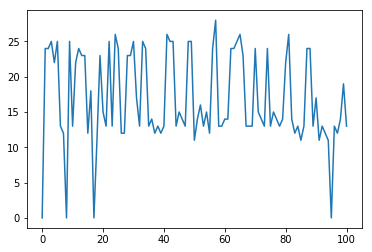

In [6]:
spielfeld = np.zeros([10,10])
spielfeld[0,:] = 2
spielfeld[9,:] = 2
spielfeld[:,0] = 2
spielfeld[:,9] = 2
spielfeld = spielfeld.astype(int)

train_and_test(0.4, 0.7, 0.6, spielfeld)